# Deep Learning Project (DD2424)


## -- INITIAL SETUP --

### 0.1 Download datasets

In [35]:
download_data = False

In [36]:
if download_data:
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

    !mkdir oxford-iiit-pet/
    !tar -xf images.tar.gz -C oxford-iiit-pet/
    !tar -xf annotations.tar.gz -C oxford-iiit-pet/
    !rm images.tar.gz
    !rm annotations.tar.gz

else:
    print("Note: Assuming that data is manually downloaded!")
    # --> Alternative is to manually download datasets here: https://www.robots.ox.ac.uk/~vgg/data/pets/
    #  Note: must have the folder "oxford-iiit-pet" in same directory as code/notebook

Note: Assuming that data is manually downloaded!


### 0.2 Define Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision

from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.ops.boxes import masks_to_boxes

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import transforms

### 0.3 Example plot

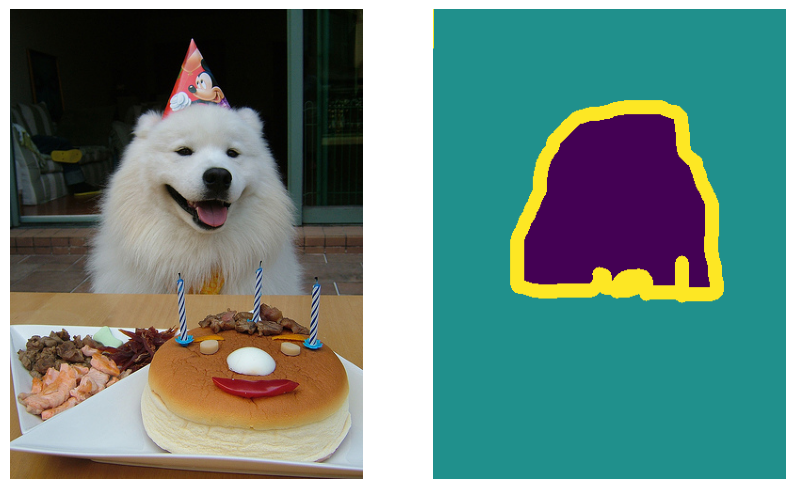

In [38]:
from torchvision.io import read_image

# -- PLOT EXAMPLE IMAGE AND MASK --
name = 'samoyed_189'
img = read_image(f'oxford-iiit-pet/images/{name}.jpg')
mask = read_image(f'oxford-iiit-pet/annotations/trimaps/{name}.png')

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)
plt.imshow(mask.permute(1, 2, 0))
plt.axis('off')
plt.show()

## -- DATA PREPROCESSING --


### 1.1 Define datasets and dataloaders and subset splits (train, validation, test):

In [85]:
# --------- Transform pipeline ---------

def transform_pipeline(in_data):
    # Define an ordered collection of functions/transformations to apply to all images
    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

def load_dataset(target_type="binary-category", ):
    ttransform = target_transform if target_type=="category" else None
    # Load in all the data within file 'trainval.txt'
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline, target_transform=ttransform, target_types=[target_type] )
    #return dataset

def target_transform(target):

    hot = torch.zeros((37))

    hot[target-1] = 1
    #cat_classes = {6, 34, 12, 27, 33, 7, 24, 21, 10, 28, 1, 8}  # set lookup is faster
    #return 0 if target in cat_classes else 1

    return hot   # if we use ["binary-category"]

def create_split_idxs(n_tot, f_train=0.8, f_valid=0.1, f_test=0.1):

    if f_train + f_valid + f_test > 1:
        print("ERROR: FACTORS TOO LARGE TO CREATE SPLITS, TRY AGAIN")

    # Range from index 0 to n==len(dataset)
    idxes = np.arange(n_tot)
    np.random.seed(42)   # random seed to ensure repeatability
    np.random.shuffle(idxes)

    # split limits:
    s1 = int(n_tot*f_train)
    s2 = int(n_tot*(f_train+f_valid))

    # Create index lists
    train_idx = idxes[:s1]
    val_idx = idxes[s1:s2]
    test_idx = idxes[s2:]

    return train_idx, val_idx, test_idx


def get_dataloaders(n_batch, f_train=0.8, f_valid=0.1, f_test=0.1, target_type="binary-category"):
    # Load in all data
    dataset = load_dataset(target_type=target_type)

    # Test it
    image, label = dataset[0]
    print(f"Image shape: {image.shape}")

    # Create shuffled index splitting for each subset
    train_idx, val_idx, test_idx = create_split_idxs(len(dataset), f_train, f_valid, f_test)

    # Split using imported Subset class
    dataset_train = Subset(dataset, train_idx)
    dataset_test = Subset(dataset, test_idx)
    dataset_val = Subset(dataset, val_idx)

    # Create data loader containing datasets
    dataloader_train = DataLoader(dataset_train, batch_size=n_batch, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=n_batch, shuffle=False, num_workers=2)
    dataloader_val = DataLoader(dataset_val, batch_size=n_batch, shuffle=True, num_workers=2)

    return dataloader_train, dataloader_test, dataloader_val


### 1.2 Plot random example images to show pre-processing (scaling and cropping)

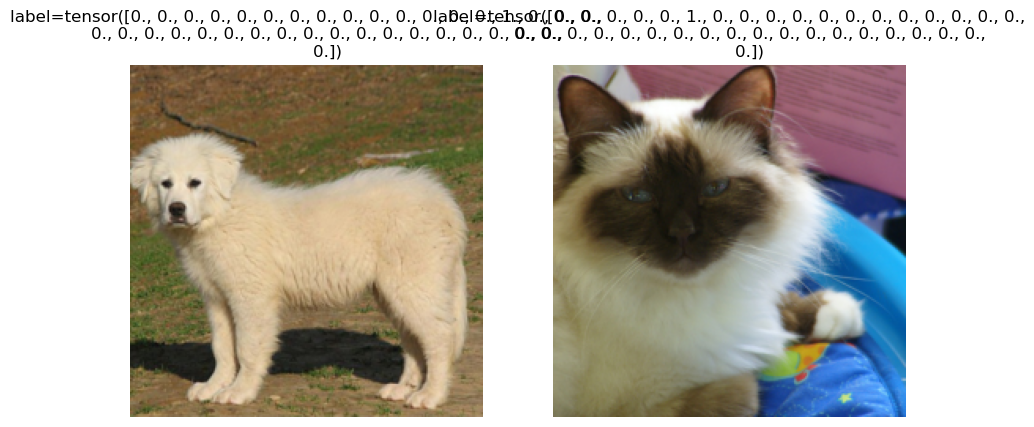

In [40]:
dataset = load_dataset("category")

#print(len(dataset[0]))

# plot example image
plt.figure(figsize=(10, 10))
plt.subplot(121)

dog = 2600
plt.imshow(dataset[dog][0].permute(1, 2, 0))
plt.axis('off')
plt.title(f"label={dataset[dog][1]}")
plt.subplot(122)

cat = 300
plt.imshow(dataset[cat][0].permute(1, 2, 0))
plt.title(f"label={dataset[cat][1]}")

plt.axis('off')

plt.show()


### (maybe todo) 1.3 Define zero-mean normalization across all data

In [41]:
def zero_mean(dataloader):
    # TODO: FIXME IF WE WANT TO DO ZERO MEAN NORMALIZATION

    #print(next(iter(dataloader_test))[0].shape)  # torch.Size([64, 3, 224, 224])
    #img = next(iter(dataloader_test))[0][0]
    #print(img.max())
    #print(img.min())
    #print(max(next(iter(dataloader_test))))

    img, _ = next(iter(dataloader))
    img = img[0]
    print(f'max: {torch.max(img)}')
    print(f'min: {torch.min(img)}')
    print(f'mean: {torch.mean(img)}')


## -- NETWORK SETUP --

### 2.0 Network Imports

In [42]:
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
from torchvision.models import resnet101
from torchvision.models import wide_resnet50_2
#from torchvision.models import resnet152

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### 2.1 Define model and training functions

In [43]:
def create_model_and_optim_binary(choice="resnet34", lr=0.001, wd=0.0005):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # As instructed, only replace final layer with same in but one out (cat/dog)
    in_features = model.fc.in_features   # size of input of final layer --> 512
    #print(model.fc.out_features)   # size of output into final layer --> 1000

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(in_features, 1)  # for binary classification instead of outputting 1000

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True   # update these layer weights (only last)

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=wd)
    # TODO: maybe look into NAG as alternative

    return model, optimizer


def train_binary(model, dataloader, optimizer, epochs=1):
    losses = []

    model = model.to(device)

    model.train()  # tells model we will train now maybe
    criterion = torch.nn.BCEWithLogitsLoss()
    # trains in batches
    for e in range(epochs):

        running_loss = 0.0

        # for each batch:
        for i, (img, binary_category) in enumerate(dataloader):

            #print(img.shape)  # torch.Size([64, 3, 224, 224])

            img = img.to("cuda")
            binary_category = binary_category.to("cuda")

            # Forward pass of network
            output = model(img)

            # Compute loss
            # TODO: check if we want to use another loss function
            loss = criterion(output, binary_category.view(-1, 1).float())

            # Compute gradients
            loss.backward()

            # Backprop
            optimizer.step()  # update weights with grads

            batch_loss = loss.item()

            losses.append(batch_loss)
            running_loss += batch_loss

            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")

            optimizer.zero_grad()  # reset grads

    return losses


## -- NETWORK TRAINING --

### 2.3 Initialize data

In [44]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="binary-category")

print("done loading data")
print("number of batches:", len(dataloader_train))



Image shape: torch.Size([3, 224, 224])
done loading data
number of batches: 81


### 2.3 Initialize model

In [45]:
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_binary, optimizer_binary = create_model_and_optim_binary(choice="resnet34", lr=0.001, wd=0.0005)


cuda == True


### 2.4 Train binary network

In [46]:
#print(torch.cuda.get_device_name(0))  # Tesla P4

print("Start training")
losses = train_binary(model_binary, dataloader_train, optimizer_binary, epochs=1)


Start training
 Epoch 1/1 : Batch 81/81 : Loss 0.15573549270629883

### 2.5 Plot losses and compute accuracy

In [47]:
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_losses(losses):
    #losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
    losses_cpu = [loss for loss in losses]
    #plt.plot(smooth(losses_cpu))
    plt.plot(losses_cpu)
    plt.xlabel("batch nr")
    plt.ylabel("training loss")


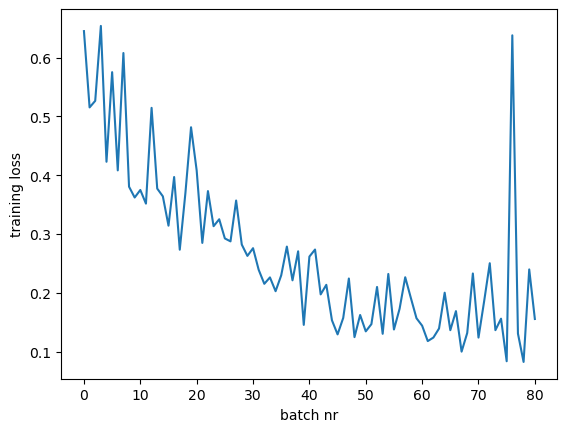

In [48]:
# Plot
plot_losses(losses)


### 2.6 Binary Accuracy

In [49]:
# TODO: FIXME
def compute_accuracy_binary(model, dataloader_test):
    total = 0
    correct = 0

    # no grad so it's faster (--> Julia edit: 'no_grad()' ensures that we can calculate with tensors without affecting it's gradients in backprop)
    with torch.no_grad():

        model.eval()

        for i, (img, binary_category) in enumerate(dataloader_test):
            img = img.to("cuda")
            binary_category = binary_category.to("cuda").view(-1, 1).float()   # torch.Size([32, 1])

            output = model(img)                                     # torch.Size([32, 1])
            prediction = torch.round(torch.sigmoid(output))         # torch.Size([32, 1])

            total += binary_category.size(0)
            correct += (prediction == binary_category).sum().item()

            print(f'\r({i+1}/{len(dataloader_test)}) accuracy: {100 * correct / total} %', end="")
        print(f'\nTest accuracy: {100 * correct / total} %')


def compute_confusion_matrix():
    pass

In [50]:
# NOTE/WARNING:
compute_accuracy_binary(model_binary, dataloader_test)

(12/12) accuracy: 97.0189701897019 %
Test accuracy: 97.0189701897019 %


## -- MULTICLASS --

### 3.1 Modify network for multiclass classification

In [136]:
def create_model_and_optim_multi(choice="resnet34", lr=0.0001, wd=0.0005, n_freeze=1, separate_scheduler=False):

    # Load in pretrained model of our choice:
    if choice == "resnet18":
        model = resnet18(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet34":
        model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet50":
        model = resnet50(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    elif choice == "resnet101":
        model = resnet101(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    else:
        print("model choice does not match")
        exit()

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(model.fc.in_features, 37)  # for binary classification instead of outputting 1000

    modules = [model.fc, model.layer4, model.layer3, model.layer2, model.layer1]
    layers_to_unfreeze = modules[:n_freeze]

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the ones we want
    for layer in layers_to_unfreeze:
        #print("freeeeze")
        for param in layer.parameters():
            param.requires_grad = True

    optimizers = []
    schedulers = []

    if separate_scheduler:
        for i, layer in enumerate(layers_to_unfreeze):
            optimizers.append(torch.optim.Adam(
                filter(lambda p: p.requires_grad, layer.parameters()),
                lr=lr*(0.5**i), # exponential decay of lr for each layer
                weight_decay=wd
            ))
            schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[i], step_size=3, gamma=0.1))
    else:
        optimizers.append(torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr,
            weight_decay=wd
        ))

        schedulers.append(torch.optim.lr_scheduler.StepLR(optimizers[0], step_size=3, gamma=0.1))

    return model, optimizers, schedulers

def train_multi(model, dataloader, optimizers, epochs=1, schedulers=[], weight=None, dataloader_val=None):
    losses = []
    val_res = {'loss': [], 'accuracy': []}
    model = model.to("cuda")
    model.train()  # tells model we will train now maybe
    criterion = torch.nn.CrossEntropyLoss(weight=weight)

    step = 0

    # trains in batches
    for e in range(epochs):
        running_loss = 0.0
        # for each batch:
        for i, (img, category) in enumerate(dataloader):
            img = img.to("cuda")
            category = category.squeeze().float().to("cuda")
            output = model(img) # Forward pass of network

            loss = criterion(output, category) # TODO: check if we want to use another loss function
            loss.backward() # Compute gradients
            for optimizer in optimizers:
                optimizer.step()# Backprop # update weights with grads
            batch_loss = loss.item()
            losses.append(batch_loss)
            running_loss += batch_loss
            print(f"\r Epoch {e+1}/{epochs} : Batch {i+1}/{len(dataloader)} : Loss {batch_loss}", end="")
            optimizer.zero_grad()  # reset grads

            step += 1

            if dataloader_val is not None and step % 50 == 0:
                # Compute accuracy on validation set
                with torch.no_grad():
                    model.eval()
                    temp_loss = np.zeros(len(dataloader_val))
                    temp_accuracy = np.zeros(len(dataloader_val))
                    for j, (img_val, category_val) in enumerate(dataloader_val):
                        img_val = img_val.to("cuda")
                        category_val = category_val.squeeze().float().to("cuda")
                        output_val = model(img_val)
                        loss_val = criterion(output_val, category_val)
                        batch_loss_val = loss_val.item()


                        temp_loss[j] = batch_loss_val
                        temp_accuracy[j] = ((torch.argmax(output_val, dim=1) == torch.argmax(category_val, dim=1)).float().mean().item())
                
                val_res['loss'].append(np.mean(temp_loss))
                val_res['accuracy'].append(np.mean(temp_accuracy))
                model.train()
        for scheduler in schedulers:
            scheduler.step()

    return losses, val_res

### 3.2 Load in multiclass data

In [52]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")

print("done loading multiclass data")
print("number of batches:", len(dataloader_train))


Image shape: torch.Size([3, 224, 224])
done loading multiclass data
number of batches: 81


### 3.3 Initialize model

In [53]:
### 2.3 Initialize model, train, and plot losses
print(f"cuda == {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model1, optimizers1, schedulers1 = create_model_and_optim_multi(choice="resnet50", lr=0.0005, wd=0.0005, n_freeze=3)
#model2, optimizer2, scheduler2 = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=2)
#model3, optimizer3, scheduler3 = create_model_and_optim_multi(choice="resnet34", lr=0.001, wd=0.0005, n_freeze=3)


cuda == True


### 3.4 Train multiclass model

In [54]:
print("Start training")
#losses = train_multi(model1, dataloader_train, optimizers1, epochs=10, schedulers=schedulers1)
#losses2 = train_multi(model2, dataloader_train, optimizer2, epochs=1)
#losses3 = train_multi(model3, dataloader_train, optimizer3, epochs=1)

Start training


### 3.5 Multiclass metric calculations

In [55]:
# TODO: FIXME
def compute_accuracy_multi(model, dataloader_test):
    total = 0
    correct = 0
    model = model.to("cuda")

    # no grad so it's faster (--> Julia edit: I think 'no_grad()' ensures that we can calculate with tensors without affecting its gradients in backprop)
    with torch.no_grad():
        model.eval()
        for i, (img, category) in enumerate(dataloader_test):
            img = img.to("cuda")
            category = torch.argmax(category, axis=1).to("cuda")  # torch.Size([32, 37]) ---> torch.Size([32])

            output = model(img)  # torch.Size([32, 37])
            # from output choose class/index with the highest value (probability?)
            prediction = torch.argmax(output, axis=1)   # torch.Size([32])

            total += category.size(0)
            correct += (prediction == category).sum().item()

    return correct / total


In [56]:
def get_predictions(model, dataloader_test):
    model = model.to(device)
    predictions = np.zeros((len(dataloader_test.dataset)))

    # no grad so it's faster (--> Julia edit: I think 'no_grad()' ensures that we can calculate with tensors without affecting its gradients in backprop)
    with torch.no_grad():
        model.eval()
        for i, (img, category) in enumerate(dataloader_test):
            img = img.to("cuda")
            category = torch.argmax(category, axis=1).to("cuda")  # torch.Size([32, 37]) ---> torch.Size([32])

            output = model(img)  # torch.Size([32, 37])
            # from output choose class/index with the highest value (probability?)
            prediction = torch.argmax(output, axis=1)   # torch.Size([32])
            predictions[i*32:(i+1)*32] = prediction.cpu().numpy()

    return predictions

Calculate precision and recall, then F1 macro score.

$ precision = \frac{TP}{TP + FP} $

$ recall = \frac{TP}{TP + FN} $

$ F_1 = \frac{2}{recall^{-1} + precision^{-1}} = \frac{2TP}{2TP + FP + FN}$

Plot distribution of true classes and predicted classes:

In [57]:
def compute_confusion_matrix(preds, y_test):
    TP = np.zeros((37))
    FP = np.zeros((37))
    TN = np.zeros((37))
    FN = np.zeros((37))

    for i in range(len(preds)):
        if preds[i] == y_test[i]:
            TP[int(preds[i])] += 1
        else:
            FP[int(preds[i])] += 1
            FN[int(y_test[i])] += 1
            TN[int(y_test[i])] += 1

    return TP, FP, TN, FN

# find f1 score for each class
def f1_score(TP, FP, TN, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1.mean()

In [58]:
def bin_conf_matrix_from_class(TP, FP, TN, FN):
    TP_BIN = np.sum(TP[:12])
    FP_BIN = np.sum(FP[:12])
    TN_BIN = np.sum(TP[12:])
    FN_BIN = np.sum(FP[12:])
    return TP_BIN, FP_BIN, TN_BIN, FN_BIN

def f1_score_binary(model, dataloader_test):
    TP, FP, TN, FN = compute_confusion_matrix(get_predictions(model, dataloader_test), y_test)
    TP_BIN, FP_BIN, TN_BIN, FN_BIN = bin_conf_matrix_from_class(TP, FP, TN, FN)
    return f1_score(TP_BIN, FP_BIN, TN_BIN, FN_BIN)

## -- EXPERIMENTS SETUP --

#### 4.1 Strategy 1

In [120]:
def train_multi_simul(num_layers, dataloader_train, dataloader_val=None, epochs=5):
    print(f"\n=== Training with {num_layers} layers unfreezed ===")
    model, optimizers, schedulers = create_model_and_optim_multi(
            choice="resnet50",
            lr=0.0001, 
            wd=0.0005, 
            n_freeze=num_layers,
            separate_scheduler=True # lwering lr exponentially for each layer
        )
    losses, val_losses = train_multi(model, dataloader_train, optimizers, epochs=epochs, schedulers=schedulers, dataloader_val=dataloader_val)
    
    return model, losses, val_losses

#### 4.2 Strategy 2

In [138]:
def train_multi_gradual(num_layers, dataloader_train, dataloader_val=None, epochs_per_layer=2):
    losses = []
    val_res = {'loss': [], 'accuracy': []}
    # Start with just the final layer
    model, optimizers, schedulers = create_model_and_optim_multi(
            choice="resnet50",
            lr=0.0005, 
            wd=0.0005, 
            n_freeze=1, 
            separate_scheduler=False
        )

    for stage in range(1, num_layers+1):  # Gradually unfreeze more layers
        print(f"Fine-tuning last {stage} layers")
        
        # Unfreeze additional layer
        if stage > 1:
            modules = [model.fc, model.layer4, model.layer3, model.layer2, model.layer1]
            layer_to_unfreeze = modules[stage-1]
            
            for param in layer_to_unfreeze.parameters():
                param.requires_grad = True
            
            # remake optimizer
            params_to_update = [ {'params': modules[i].parameters(), 'lr': 0.0005*(0.5**(i))} for i in range(stage)]
            optimizers[0] = torch.optim.Adam(
                params_to_update,
                weight_decay=0.0005
            )
            # optimizers.append(torch.optim.Adam(
            #     layer_to_unfreeze.parameters(),
            #     lr=0.0005*(0.5**(stage-1)), # exponential decay of lr for each layer
            #     weight_decay=0.0005
            # ))
            # add scheduler for the new layer
            schedulers[0] = torch.optim.lr_scheduler.StepLR(optimizers[0], step_size=3, gamma=0.1)
        
        # train for a few epochs
        state_losses, state_val_res = train_multi(model, dataloader_train, optimizers, epochs=epochs_per_layer, schedulers=schedulers, dataloader_val=dataloader_val)
        losses.extend(state_losses)
        val_res['loss'].extend(state_val_res['loss'])
        val_res['accuracy'].extend(state_val_res['accuracy'])
    return model, losses, val_res

#### 4.3 Data augmentation

In [61]:
# transform pipeline for data augmentation
def transform_pipeline_augmented(in_data):
    """Transform pipeline with data augmentation"""
    pipeline = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)

# create augmented dataset
def load_dataset_augmented(target_type="category"):
    ttransform = target_transform if target_type=="category" else None
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline_augmented,
                        target_transform=ttransform, target_types=[target_type])


Choose the best model of strategy 1 and 2 and train with data augmentation. 

### 4.4 Imbalanced Classes

#### Setup

In [62]:
def create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.2):
    """Create an imbalanced dataset by reducing cat breed samples"""
    cat_classes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}  # First 12 classes are cats
    
    imbalanced_data = []
    imbalanced_labels = []
    
    # Process each sample
    for img, label in dataloader_train.dataset:
        class_idx = torch.argmax(label).item()
        
        if class_idx in cat_classes:
            # Keep only 20% of cat breeds
            if np.random.random() < imbalance_ratio:
                imbalanced_data.append(img)
                imbalanced_labels.append(label)
        else:
            # Keep all dog breeds
            imbalanced_data.append(img)
            imbalanced_labels.append(label)
    
    # Create TensorDataset NOTE: might not work
    imbalanced_dataset = torch.utils.data.TensorDataset(
        torch.stack(imbalanced_data),
        torch.stack(imbalanced_labels),
    )
    
    return DataLoader(imbalanced_dataset, batch_size=32, shuffle=True)

# Create imbalanced dataset
#imbalanced_loader = create_imbalanced_dataset(dataloader_train, imbalance_ratio=0.05)

In [63]:
# class_counts = torch.zeros(37)
# for _, labels in imbalanced_loader:
#     for label in labels:
#         class_idx = torch.argmax(label).item()
#         class_counts[class_idx] += 1

# class_weights = 1 / (class_counts + 1e-6)
# class_weights = class_weights / class_weights.mean()  # Normalize

In [64]:
# y_test = np.zeros((len(dataloader_test.dataset)))
# for i, (img, category) in enumerate(dataloader_test):
#     y_test[i*32:(i+1)*32] = torch.argmax(category, axis=1).cpu().numpy()

#### Unweighted cross-entropy

In [65]:
##model_simul_imb = train_multi_simul(2, imbalanced_loader)
#model_gradual_imb = train_multi_gradual(2, imbalanced_loader)

In [66]:
#print("f1 score imb classes: ", f1_score_binary(model_simul_imb, dataloader_test))
#print("f1 score standard classes: ", f1_score_binary(model_aug_s1, dataloader_test))

#### Weighted cross-entropy training


In [67]:
# m_imb_w, opt_w, sch_w = create_model_and_optim_multi(
#         choice="resnet50", 
#         lr=0.0005, 
#         wd=0.0005, 
#         n_freeze=2
#     )
# l_imb_w = train_multi(
#         m_imb_w, 
#         imbalanced_loader, 
#         opt_w, 
#         epochs=5, 
#         schedulers=sch_w, 
#         weight=class_weights.to(device)
#     )

In [68]:
# f1 = f1_score_binary(m_imb_w, dataloader_test)
# print("f1 score imb classes: ", f1)

## -- EXTENSION 1: Implementing ViT --

### 1.0 Imports??

In [69]:
if True:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    from tqdm import tqdm
    import torchvision

    from torchvision.io import read_image
    from torchvision.transforms import ToTensor
    from torchvision.ops.boxes import masks_to_boxes

    from torchvision.datasets import OxfordIIITPet
    from torch.utils.data import DataLoader
    from torch.utils.data import Subset
    from torchvision.transforms import transforms

# ---- ABOVE IS DEFINED IN FIRST PART, BUT FOR NOW ONLY RUN EXTENSION CELLS---
from torchvision import datasets, transforms
from transformers import ViTImageProcessor, ViTImageProcessorFast, ViTForImageClassification, TrainingArguments, Trainer, get_scheduler
from evaluate import load
from datasets import load_dataset


breed_dict = {
    1: "Abyssinian",
    2: "American Bulldog",
    3: "American Pit Bull Terrier",
    4: "Basset Hound",
    5: "Beagle",
    6: "Bengal",
    7: "Birman",
    8: "Bombay",
    9: "Boxer",
    10: "British Shorthair",
    11: "Chihuahua",
    12: "Egyptian Mau",
    13: "English Cocker Spaniel",
    14: "English Setter",
    15: "German Shorthaired",
    16: "Great Pyrenees",
    17: "Havanese",
    18: "Japanese Chin",
    19: "Keeshond",
    20: "Leonberger",
    21: "Main Coon",
    22: "Miniature Pinscher",
    23: "Newfoundland",
    24: "Persian",
    25: "Pomeranian",
    26: "Pug",
    27: "Ragdoll",
    28: "Russian Blue",
    29: "Saint Bernard",
    30: "Samoyed",
    31: "Scottish Terrier",
    32: "Shiba Inu",
    33: "Siamese",
    34: "Sphynx",
    35: "Staffordshire Bull Terrier",
    36: "Wheaten Terrier",
    37: "Yorkshire Terrier"
}

/home/pontus/.conda/envs/deep-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (Only do once / first time) Convert directory structure to match for Dataset thing

In [70]:
# FOLLOWING THIS: https://medium.com/@diego.machado/fine-tuning-vit-for-image-classification-with-hugging-face-48c4be31e367

## Creating 🤗 Dataset structure
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import os
import shutil


def restructure_dir_for_dataset():
    #  ----1. Split Data

    # Get file names and breed names
    list_path = "oxford-iiit-pet/annotations/list.txt"
    labels = pd.read_csv(list_path, sep=" ", header=None, names=["file_name", "class_nr", "species_code", "species_nr"])
    print(labels)
    print(labels.file_name[0])

    X = labels.file_name      # id name of file
    y = labels.class_nr       # breed name  --> CHANGED TO CLASS NUMBER TODO ??? KEEP NOTE OF

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, shuffle = True, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=13, shuffle = True, stratify = y_train)
    train_data = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
    val_data = pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
    test_data = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)


    # CREATE AND PREPARE DIRECTORY STUCTURE
    if not os.path.exists("PetClassification"):
        # NOTE ONLY DO ONCE:
        # 2. make Dataset Dir and splits
        DatasetDir = Path("PetClassification")
        os.mkdir(DatasetDir)
        os.mkdir(DatasetDir/"train")
        os.mkdir(DatasetDir/"validation")
        os.mkdir(DatasetDir/"test")

        # 3. make classes (breeds) dir
        for class_nr in tqdm(train_data.class_nr.unique()):
          os.mkdir(DatasetDir/"train"/f"{class_nr}")
          os.mkdir(DatasetDir/"validation"/ f"{class_nr}")
          os.mkdir(DatasetDir/"test"/f"{class_nr}")

        # 4. moving images to split folder and breed
        IMG_PATH = "oxford-iiit-pet/images"
        def make_split_folder(split_df, split):
          # iterate over dataset
          for idx, row in tqdm(split_df.iterrows(), total = len(split_df), desc = f"Making {split} folder"):
            img_name, class_nr = row
            # copy files
            shutil.copyfile(f"{os.path.join(IMG_PATH, img_name)}.jpg", f"{DatasetDir/split/str(class_nr)/img_name}.jpg")

        make_split_folder(train_data, "train")
        make_split_folder(val_data, "validation")
        make_split_folder(test_data, "test")

        print("DONE MOVING FILES")
    else:
        print("Warning: Path already exists!")

# NOTE: ONLY DO THIS ONCE
#restructure_dir_for_dataset()



### 1.1  Load Hugging Face's image processor (ViT processor)

In [71]:
"""
To make sure we apply the correct transformations, we will use a ViTImageProcessor initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the google/vit-base-patch16-224-in21k model, so let's load its image processor from the Hugging Face Hub.
"""

model_name_or_path = 'google/vit-base-patch16-224-in21k'    # TODO: LOOK INTO AND MAYBE PICK ANOTHER MODEL

processor = ViTImageProcessor.from_pretrained(model_name_or_path)   # Load Hugging Face's image processor

### (MAYBE NOT NEEDED ANYMORE) 1.2 Define dataset functions and image transforms

In [72]:
# NOTE FOR LATER: ALL THAT IS CHANGED IS THE TRANSFORM PIPELINE.

# TODO: MAYBE, COMBINE WITH VERSION AT START OF FILE

# TODO FIX MAYBE:
transform_for_vit = transforms.Compose([
        transforms.Resize((224)),     # NOTE: WE DONT CENTER CROP
        transforms.CenterCrop(224),
        #transforms.PILToTensor(),   # from old version
        #transforms.ConvertImageDtype(torch.float),  # from old version
        #transforms.Normalize(mean=processor.image_mean, std=processor.image_std)   # messes with processor???
        ])

#pipeline = transforms.Compose([
#    transforms.Resize(224),
#    transforms.CenterCrop(224),
#    transforms.PILToTensor(),
#    transforms.ConvertImageDtype(torch.float),
#])


def transform_vit(example_batch):
    # Take a list of PIL images and turn them to pixel values

    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
    ])
    # Apply the transform pipeline to the images
    example_batch['image'] = [pipeline(x) for x in example_batch['image']]

    rgb_images = [x.convert("RGB") if x.mode == "RGBA" else x for x in example_batch['image']]
    inputs = processor(rgb_images, return_tensors="pt")

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

def load_dataset_vit(target_type="category"):
    ttransform = target_transform_vit if target_type=="category" else None
    # Load in all the data within file 'trainval.txt'
    return OxfordIIITPet(root='.', download=False, transform=transform_pipeline_vit, target_transform=ttransform, target_types=[target_type] )

def target_transform_vit(target):   # 1-37
    #print(target) # TODO: WARNING: NOTE: arg 'target' is 0-indexed // Julia 15 Maj
    hot = torch.zeros((37))
    hot[target] = 1   # NOTE: CHANGED FROM -->  # hot[target-1] = 1   # NOTE: PREVISOU VERSION SHIFTS EVERYTHING BACK ON STEP IN LIST
    return hot   # if we use ["binary-category"]



### 1.3 Load in dataset according to DataSet class used in tutorial

In [73]:
ds = load_dataset('PetClassification')
labels = ds["train"].features["label"].names

### 1.4 Define processor and process dataset

In [74]:
"""
To process an image, simply pass it to the image 'processor''s call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model. You get a NumPy array by default, but if you add the return_tensors='pt' argument, you'll get back torch tensors instead.
"""

def transform_vit_aug(example_batch):
    # Take a list of PIL images and turn them to pixel values

    pipeline = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
    # Apply the transform pipeline to the images
    images = [pipeline(x) for x in example_batch['image']]

    rgb_images = [x.convert("RGB") if x.mode == "RGBA" else x for x in images]
    inputs = processor(rgb_images, return_tensors="pt")

    inputs['labels'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform_vit_aug)
prepared_ds_no_aug = ds.with_transform(transform_vit)

## Training and Evaluation ViT

### Define Collate Function

In [75]:
"""
Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.
Since the collate_fn will return a batch dict, you can **unpack the inputs to the model later
"""

# Define a collate function??? --> seems to put together batches of processed data  (adding dimension in first position??)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])  # stack???
    }


### Define Evaluation metric

In [76]:
"""
The accuracy metric from evaluate can easily be used to compare the predictions with the labels. Below, you can see how to use it within a compute_metrics function that will be used by the Trainer.
"""

metric = load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


### Define label-to-class translations (unsure if needed)

In [77]:
# TODO: FIX AND LOOK INTO NOW THAT WE CHANGED TO DATASET
def onehot_to_number(onehot_label):
    return torch.argmax(onehot_label).item() + 1   # NOTE: Class numbers starts index at 1

def number_to_name(num):
    return breed_dict[num]


### Initialize Pretrained model (ViTForImageClassification)

In [78]:
"""
Let's load the pretrained model. We'll add num_labels on init so the model creates a classification head with the right number of units. We'll also include the id2label and label2id mappings to have human-readable labels in the Hub widget (if you choose to push_to_hub).
"""
def get_model():
    model = ViTForImageClassification.from_pretrained(
        model_name_or_path,
        num_labels=len(labels),
        id2label={str(i): c for i, c in enumerate(labels)},
        label2id={c: str(i) for i, c in enumerate(labels)}
    )
    return model

### Set up training arguments

In [159]:
def get_training_args(label_smoothing_factor=0, num_epochs=6):
  training_args = TrainingArguments(
    output_dir="./vit-base-oxford-pet",
    per_device_train_batch_size=16,
    eval_strategy="steps",
    num_train_epochs=num_epochs,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    label_smoothing_factor=label_smoothing_factor,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='none', #'tensorboard',
    load_best_model_at_end=True,
  )
  return training_args


In [80]:
def create_trainer(model, training_args, optimizer, ds, scheduler=None):
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=ds["train"], 
        eval_dataset=ds["validation"],
        processing_class=processor,
        optimizers=(optimizer, scheduler),
    )
    return trainer

In [81]:
# same process as before but we send optimizer to the trainer instead 
def setup_vit_model(ds, num_encoder_layers=0, model=None, num_epochs=6):
    if model is None:
        model = get_model()

    training_args = get_training_args(num_epochs=num_epochs)

    for param in model.parameters():
        param.requires_grad = False

    params_to_optim = [{'params': model.classifier.parameters(), 'lr': 1e-4}]
    for param in model.classifier.parameters():
        param.requires_grad = True

    for i in range(11, 11-num_encoder_layers, -1):
        params_to_optim.append({'params': model.vit.encoder.layer[i].parameters(), 'lr': 5e-5*(0.5**(11-i))})
        
        for param in model.vit.encoder.layer[i].parameters():
            param.requires_grad = True


    optimizer = torch.optim.Adam(params_to_optim, weight_decay=0.0005)

    scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=50,
        num_training_steps=int(len(ds["train"]) * training_args.num_train_epochs),
    )

    trainer = create_trainer(model, training_args, optimizer, ds, scheduler=scheduler)

    return model, trainer

In [82]:
def test_transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    # Apply the transform pipeline to the images
    rgb_images = [x.convert("RGB") if x.mode == "RGBA" else x for x in example_batch['image']]
    inputs = processor([x for x in rgb_images], return_tensors="pt")

    inputs['labels'] = example_batch['label']
    return inputs

prepared_ds_test = ds.with_transform(test_transform)

### TRAIN ViT

In [153]:
# print all eval accuracies in log history of trainer_vit
def get_eval_history(trainer):
    accs = []
    for i, eval in enumerate(trainer.state.log_history):
        if "eval_accuracy" in eval:
            accs.append(eval['eval_accuracy'])
    return accs

In [ ]:
acc_hist_grad_aug
#0.9347

[0.6972789115646258,
 0.8248299319727891,
 0.8367346938775511,
 0.8758503401360545,
 0.8775510204081632,
 0.8894557823129252,
 0.8996598639455783,
 0.9013605442176871,
 0.8928571428571429,
 0.9047619047619048,
 0.9081632653061225,
 0.9098639455782312,
 0.9132653061224489,
 0.9115646258503401,
 0.9013605442176871,
 0.9166666666666666,
 0.9200680272108843,
 0.9149659863945578]

In [ ]:
acc_hist_grad_no_aug
#0.9395

[0.6972789115646258,
 0.8384353741496599,
 0.8605442176870748,
 0.8826530612244898,
 0.891156462585034,
 0.9047619047619048,
 0.9030612244897959,
 0.9166666666666666,
 0.9047619047619048,
 0.9217687074829932,
 0.9166666666666666,
 0.9268707482993197,
 0.923469387755102,
 0.9200680272108843,
 0.9200680272108843,
 0.9387755102040817,
 0.9319727891156463,
 0.9421768707482994]

In [ ]:
acc_hist_simul_no_aug
# 0.9435

[[0.7687074829931972,
  0.8622448979591837,
  0.8554421768707483,
  0.9166666666666666,
  0.9047619047619048,
  0.9183673469387755,
  0.9200680272108843,
  0.9251700680272109,
  0.9336734693877551,
  0.9285714285714286,
  0.9183673469387755,
  0.9319727891156463,
  0.9336734693877551,
  0.9183673469387755,
  0.9370748299319728,
  0.935374149659864,
  0.9302721088435374,
  0.9336734693877551,
  0.9285714285714286]]

In [ ]:
acc_hist_simul_aug
# 0.9422

[[0.7431972789115646,
  0.826530612244898,
  0.8520408163265306,
  0.891156462585034,
  0.891156462585034,
  0.9149659863945578,
  0.9132653061224489,
  0.9200680272108843,
  0.9132653061224489,
  0.9047619047619048,
  0.9030612244897959,
  0.9200680272108843,
  0.9217687074829932,
  0.9200680272108843,
  0.9404761904761905,
  0.9387755102040817,
  0.9217687074829932,
  0.9217687074829932,
  0.9302721088435374]]

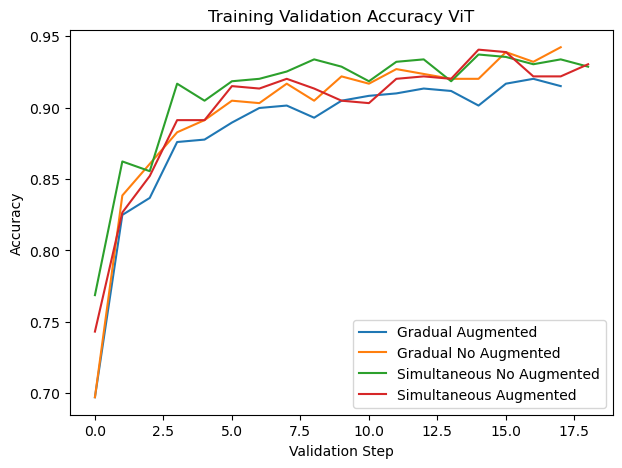

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(acc_hist_grad_aug, label="Gradual Augmented")
ax.plot(acc_hist_grad_no_aug, label="Gradual No Augmented")
ax.plot(acc_hist_simul_no_aug[0], label="Simultaneous No Augmented")
ax.plot(acc_hist_simul_aug[0], label="Simultaneous Augmented")

ax.set_title("Training Validation Accuracy (ViT)")

ax.set_xlabel("Validation Step")
ax.set_ylabel("Accuracy")

ax.legend()
plt.show()

In [ ]:
 = [acc for temp_list in acc_history for acc in temp_list]

In [182]:
acc_hist_simul_aug = [acc for acc in acc_history]

In [181]:
acc_history = []

model_vit_aug, trainer_vit = setup_vit_model(prepared_ds, num_encoder_layers=3, num_epochs=6)
train_results = trainer_vit.train()

acc_history.append(get_eval_history(trainer_vit))

# for i in range(1,3):
#     print(f"Training with {i+1} layers unfrozen")
#     model_vit_aug, trainer_vit = setup_vit_model(prepared_ds_no_aug, num_encoder_layers=i+1, model=model_vit_aug, num_epochs=2)
#     train_results = trainer_vit.train()
#     acc_history.append(get_eval_history(trainer_vit))


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,3.179200,3.148726,0.743197
200,2.446200,2.399127,0.826531
300,1.784900,1.758794,0.852041
400,1.302900,1.279626,0.891156
500,0.880600,0.958867,0.891156
600,0.765000,0.741797,0.914966
700,0.520500,0.598696,0.913265
800,0.456100,0.498181,0.920068
900,0.411700,0.447174,0.913265
1000,0.356100,0.420510,0.904762


In [ ]:
trainer_vit.save_model("vit-gradual-")
trainer_vit.log_metrics("train", train_results.metrics)
trainer_vit.save_metrics("train", train_results.metrics)
trainer_vit.save_state()

In [ ]:
trainer_vit.output_dir = "./vit-aug-10-epochs"

### EVALUATE ViT

In [184]:
metrics = trainer_vit.evaluate(prepared_ds_test['test'])
trainer_vit.log_metrics("eval", metrics)
trainer_vit.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        6.0
  eval_accuracy           =     0.9422
  eval_loss               =     0.2567
  eval_runtime            = 0:00:08.51
  eval_samples_per_second =    172.599
  eval_steps_per_second   =     21.604


## -- EXPERIMENTS --

In [99]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders(n_batch=32, f_train=0.7, f_test=0.1, f_valid=0.2, target_type="category")

dataset_aug = load_dataset_augmented(target_type="category")
train_idx, val_idx, test_idx = create_split_idxs(len(dataset_aug), 0.7, 0.2, 0.1)

dataloader_train_aug = DataLoader(Subset(dataset_aug, train_idx), batch_size=32, shuffle=True)
dataloader_val = DataLoader(Subset(dataset, val_idx), batch_size=32, shuffle=False)
dataloader_test = DataLoader(Subset(dataset, test_idx), batch_size=32, shuffle=False)

Image shape: torch.Size([3, 224, 224])


### Augmentation testing

In [94]:
def run_gradual_training(dataloader_train, dataloader_val, num_layers=2, epochs_per_layer=2):
    model, res_train, res_val = train_multi_gradual(num_layers, dataloader_train, dataloader_val=dataloader_val, epochs_per_layer=epochs_per_layer)
    return model, res_train, res_val

def run_simul_training(dataloader_train, dataloader_val, num_layers=2, epochs=5):
    model, res_train, res_val = train_multi_simul(num_layers, dataloader_train, dataloader_val=dataloader_val, epochs=epochs)
    return model, res_train, res_val

### Compare effect of data aug ViT vs. ResNet

In [139]:
model_s2_aug, s2_aug_loss, s2_aug_acc = run_gradual_training(dataloader_train_aug, dataloader_val, num_layers=3, epochs_per_layer=2)

Fine-tuning last 1 layers
 Epoch 2/2 : Batch 81/81 : Loss 1.4419492483139038Fine-tuning last 2 layers
 Epoch 2/2 : Batch 81/81 : Loss 0.3530026972293854Fine-tuning last 3 layers
 Epoch 2/2 : Batch 81/81 : Loss 0.280852258205413855

In [123]:
model_s1_aug, s1_aug_loss, s1_aug_acc = run_simul_training(dataloader_train_aug, dataloader_val, num_layers=3, epochs=6)


=== Training with 3 layers unfreezed ===
 Epoch 6/6 : Batch 81/81 : Loss 0.13997398316860293

In [141]:
model_s2, s2_loss, s2_acc = run_gradual_training(dataloader_train, dataloader_val, num_layers=3, epochs_per_layer=2)

Fine-tuning last 1 layers
 Epoch 2/2 : Batch 81/81 : Loss 1.2059767246246338Fine-tuning last 2 layers
 Epoch 2/2 : Batch 81/81 : Loss 0.05962001532316208Fine-tuning last 3 layers
 Epoch 2/2 : Batch 81/81 : Loss 0.250216603279113774

In [127]:
model_s1, s1_loss, s1_acc = run_simul_training(dataloader_train, dataloader_val, num_layers=3, epochs=6)


=== Training with 3 layers unfreezed ===
 Epoch 6/6 : Batch 81/81 : Loss 0.162593662738800058

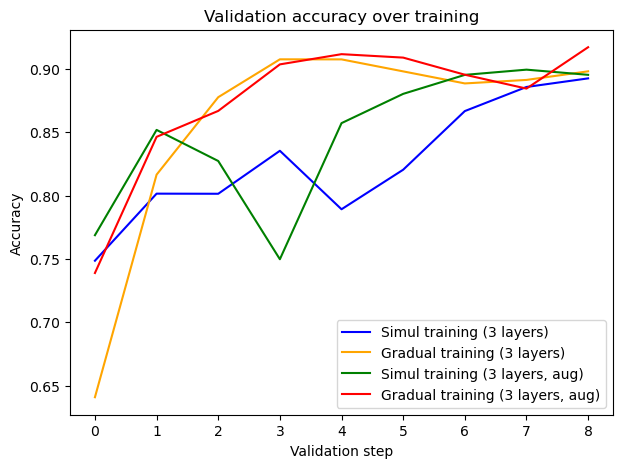

In [145]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
# plot the accuracies over training
ax.plot(s1_acc['accuracy'], label='Simul training (3 layers)', color='blue')
ax.plot(s2_acc['accuracy'], label='Gradual training (3 layers)', color='orange')
ax.plot(s1_aug_acc['accuracy'], label='Simul training (3 layers, aug)', color='green')
ax.plot(s2_aug_acc['accuracy'], label='Gradual training (3 layers, aug)', color='red')

ax.set_xlabel('Validation step')
ax.set_ylabel('Accuracy')
ax.set_title('Validation accuracy over training')
ax.legend()
plt.show()


In [143]:
print(f"{compute_accuracy_multi(model_s2_aug, dataloader_test)}")

0.926829268292683


In [144]:
#names = ['s1-1layer', 's2-2layer', 'aug-s1-1layer', 'aug-s2-2layer']
for i, model in enumerate([model_s1, model_s2, model_s1_aug, model_s2_aug]):
    acc = compute_accuracy_multi(model, dataloader_test)
 #   torch.save(model.state_dict(), f"resnet-{names[i]}.pth")
    print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9214
Accuracy: 0.9160
Accuracy: 0.9322
Accuracy: 0.9268


In [ ]:
# load torch models from local
def load_model(model_path):
    model = torchvision.models.resnet50(weights='DEFAULT')
    model.fc = torch.nn.Linear(model.fc.in_features, 37)  # for binary classification instead of outputting 1000
    model.load_state_dict(torch.load(model_path))
    return model

aug_models_s1 = []
no_aug_models_s1 = []
aug_models_s2 = []
no_aug_models_s2 = []

aug_models_s1.append(load_model(f"resnet-aug-s1-1layer.pth"))
no_aug_models_s1.append(load_model(f"resnet-s1-1layer.pth"))

for i in range(2, 4):
    aug_models_s1.append(load_model(f"resnet-aug-s1-{i}layer.pth"))
    no_aug_models_s1.append(load_model(f"resnet-s1-{i}layer.pth"))
    aug_models_s2.append(load_model(f"resnet-aug-s2-{i}layer.pth"))
    no_aug_models_s2.append(load_model(f"resnet-s2-{i}layer.pth"))

In [ ]:
for model in aug_models_s1:
    
    model.eval()
    print(f"s1 w/ aug {compute_accuracy_multi(model, dataloader_test):.4f}")
for model in no_aug_models_s1:
    model.eval()
    print(f"s1 no aug {compute_accuracy_multi(model, dataloader_test):.4f}")
for model in aug_models_s2:
    model.eval()
    print(f" s2 w/ aug{compute_accuracy_multi(model, dataloader_test):.4f}")
for model in no_aug_models_s2:
    model.eval()
    print(f"s2 no aug {compute_accuracy_multi(model, dataloader_test):.4f}")

s1 w/ aug 0.9267
s1 w/ aug 0.9389
s1 w/ aug 0.9050
s1 no aug 0.9322
s1 no aug 0.9389
s1 no aug 0.9172
 s2 w/ aug0.9403
 s2 w/ aug0.8996
s2 no aug 0.9362
s2 no aug 0.9064


In [ ]:
vit_val_acc = np.array([x['eval_accuracy'] for x in trainer.state.log_history if 'eval_accuracy' in x])
vit_idx = np.round(np.linspace(0, len(vit_val_acc)-1, len(s1_acc['accuracy']))).astype(int)

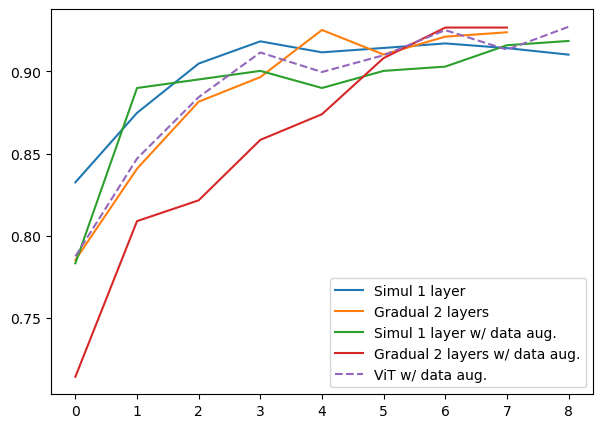

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(s1_acc['accuracy'], label='Simul 1 layer')
ax.plot(s2_acc['accuracy'], label='Gradual 2 layers')
ax.plot(s1_aug_acc['accuracy'], label='Simul 1 layer w/ data aug.')
ax.plot(s2_aug_acc['accuracy'], label='Gradual 2 layers w/ data aug.')

ax.plot(vit_val_acc[vit_idx], label='ViT w/ data aug.', linestyle='--')

ax.legend()
plt.show()

In [ ]:
no_aug_models = []
aug_models = []

for i in range(1, 4):
    no_aug_models.append(ViTForImageClassification.from_pretrained(f"vit-{i}layer-6epochs"))

for i in range(1, 4):
    aug_models.append(ViTForImageClassification.from_pretrained(f"vit-aug-{i}layer-6epochs"))

In [ ]:
# compute accuracy on 
ds_test = ds.with_transform(transform_vit)

for i, model in enumerate(no_aug_models):
    trainer = create_trainer(model, get_training_args(), None, ds_test)
    metrics = trainer.evaluate(ds_test['test'])
    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)
    print(f"Model {i+1} accuracy: {metrics['eval_accuracy']}")


***** eval metrics *****
  eval_accuracy               =     0.9088
  eval_loss                   =     1.2124
  eval_model_preparation_time =     0.0016
  eval_runtime                = 0:00:09.43
  eval_samples_per_second     =    155.833
  eval_steps_per_second       =     19.506
Model 1 accuracy: 0.908843537414966


***** eval metrics *****
  eval_accuracy               =     0.9299
  eval_loss                   =     0.9065
  eval_model_preparation_time =     0.0017
  eval_runtime                = 0:00:09.51
  eval_samples_per_second     =    154.424
  eval_steps_per_second       =     19.329
Model 2 accuracy: 0.9299319727891157


***** eval metrics *****
  eval_accuracy               =     0.9401
  eval_loss                   =      0.858
  eval_model_preparation_time =     0.0018
  eval_runtime                = 0:00:09.49
  eval_samples_per_second     =    154.743
  eval_steps_per_second       =     19.369
Model 3 accuracy: 0.9401360544217687


In [ ]:
# compute accuracy on 
ds_test = ds.with_transform(transform_vit)

for i, model in enumerate(aug_models):
    trainer = create_trainer(model, get_training_args(), None, ds_test)
    metrics = trainer.evaluate(ds_test['test'])
    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)
    print(f"Model {i+1} accuracy: {metrics['eval_accuracy']}")


***** eval metrics *****
  eval_accuracy               =     0.9075
  eval_loss                   =     1.2316
  eval_model_preparation_time =     0.0042
  eval_runtime                = 0:00:09.12
  eval_samples_per_second     =    161.071
  eval_steps_per_second       =     20.161
Model 1 accuracy: 0.9074829931972789


***** eval metrics *****
  eval_accuracy               =     0.9252
  eval_loss                   =     0.9211
  eval_model_preparation_time =     0.0015
  eval_runtime                = 0:00:09.21
  eval_samples_per_second     =    159.442
  eval_steps_per_second       =     19.957
Model 2 accuracy: 0.9251700680272109


***** eval metrics *****
  eval_accuracy               =     0.9293
  eval_loss                   =     0.8933
  eval_model_preparation_time =     0.0025
  eval_runtime                = 0:00:09.75
  eval_samples_per_second     =    150.624
  eval_steps_per_second       =     18.854
Model 3 accuracy: 0.9292517006802721
